In [1]:
import ebf
import healpix_util as hu
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import healpy as hp
import astropy.stats as st
import astropy.visualization as av

In [2]:
def plotPixels(x, y, pixel_array, mapSky, pixelImages, plotEach=False, 
               xlim=(-2, 2.5), ylim=(2, -1), vmin=0.01, vmax=10., 
               xlabel='log distance', ylabel='log proper motion', 
               fignameAll='pofd_allPixels.pdf', fignameEachpre='pofd', 
               bins=100, normed=False, norm=None, cmap='Greys', dynRange=100., grid=False, npixels=None):
    if npixels is None: npixels = np.max(pixel_array)
    fig, axes = plt.subplots(4*nside, 3*nside, figsize=(7*nside, 7*nside))
    axes = axes.flatten()
    if plotEach: fignow, axesnow = plt.subplots(1, 2, figsize=(10, 5))
    #loop over pixel on sky
    for ax, pixel_index in zip(axes, range(np.max(pixel_array)+1)):
        axesnow[0].cla()
        axesnow[1].cla()
        index = pixel_array == pixel_index
        if np.sum(index):
            for axis in [ax, axesnow[0]]:
                counts, xedges, yedges = np.histogram2d(x[index], y[index], bins=bins, normed=normed)
                if norm == 'lognorm': 
                    minhist = np.min(counts[counts > 0])
                    norm=mpl.colors.LogNorm(vmin=minhist, vmax=minhist*dynRange)
                axis.imshow(counts, origin='lower', extent=[np.min(xedges), np.max(xedges), np.min(yedges), np.max(yedges)], cmap=cmap, norm=norm)
                axis.set_xlim(xlim)
                axis.set_ylim(ylim)
                axis.set_xlabel(xlabel)
                axis.set_ylabel(ylabel)
                axis.grid()
            axesnow[1].imshow(mapSky, origin='lower', extent=[-180, 180, -90, 90])
            axesnow[1].imshow(pixelImages[pixel_index], origin='lower', cmap='Greys', alpha=0.3, extent=[-180, 180, -90, 90])
            axesnow[1].set_xlabel('l')
            axesnow[1].set_ylabel('b')
            fignow.savefig('{0}_{1:03d}.pdf'.format(fignameEachpre, pixel_index), rasterized=True)
    fig.savefig(fignameAll)
    plt.close(fig)
    plt.close(fignow)

In [8]:
#datafile = 'sdssHalo.ebf'
datafile = '../GalaxiaData/sdssgalaxy_10percent.ebf'
#datafile = '../GalaxiaData/sdssgalaxy_1percent.ebf'
#datafile = '../GalaxiaData/sdssHalo.ebf'
data = ebf.read(datafile, '/')

In [9]:
data.keys()

['rad',
 'exbv_solar',
 'teff',
 'sdss_g',
 'mag2',
 'mag1',
 'mag0',
 'sdss_r',
 'sdss_u',
 'satid',
 'vx',
 'vy',
 'vz',
 'sdss_z',
 'mtip',
 'log',
 'pz',
 'px',
 'py',
 'feh',
 'exbv_schlegel',
 'sdss_i',
 'lum',
 'exbv_schlegel_inf',
 'mact',
 'glon',
 'popid',
 'glat',
 'alpha',
 'center',
 'partid',
 'age',
 'grav',
 'smass',
 'fieldid']

In [10]:
c = coord.Galactic(u=data['px']*u.kpc, v=data['py']*u.kpc, w=data['pz']*u.kpc,
                 U=data['vx']*u.km/u.s, V=data['vy']*u.km/u.s, W=data['vz']*u.km/u.s,
                 representation=coord.CartesianRepresentation, differential_cls=coord.CartesianDifferential)
c.set_representation_cls(coord.SphericalRepresentation, s=coord.SphericalCosLatDifferential)

pm = np.sqrt(c.pm_b**2. + c.pm_l_cosb**2.)


plt.hist2d(data['sdss_g'] - data['sdss_i'], redpm, bins=250, norm=mpl.colors.LogNorm())
plt.title('Reduced Proper Motion')
plt.gca().invert_yaxis()

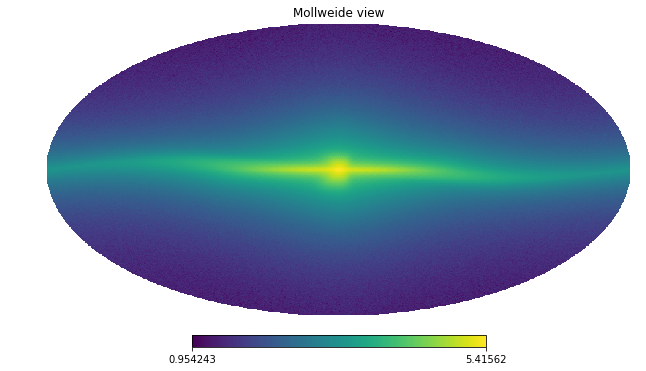

In [11]:
#for visualizing all data on the sky 
nside = 128
hpixMap = hu.HealPix("ring", nside)
pixnums = hpixMap.eq2pix(data['glon'], data['glat'])
omap = np.bincount(pixnums, minlength=hpixMap.npix)
mapSky = hp.mollview(np.log10(omap), return_projected_map=True)
plt.savefig('pofd_allsky.pdf')

In [9]:
pmb = np.random.normal(loc=c.pm_b, scale=2)
pml = np.random.normal(loc=c.pm_l_cosb, scale=2)

In [14]:
def matrixize(data, err):
    """
    vectorize the 2 pieces of data into a 2D mean and 2D covariance matrix
    """
    X = np.vstack(data).T
    Xerr = np.zeros(X.shape + X.shape[-1:])
    diag = np.arange(X.shape[-1])
    Xerr[:, diag, diag] = np.vstack([e**2. for e in err]).T
    return X, Xerr

In [12]:
import itertools
from scipy import linalg
from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


In [16]:
X, Xerr = matrixize([data['glon'], data['glat'], c.pm_l_cosb, c.pm_b], [0, 0, 0, 0])

In [ ]:
# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
np.save('gmm_n5_galactic', gmm)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=5,
                                        covariance_type='full').fit(X)
np.save('dpgmm_n5_galactic', dpgmm)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

plt.show()

In [ ]:
y = pmb #symlog(pmb)
x = pml #symlog(pml)
y = np.sign(y)*np.log10(np.abs(y) + 1)
x = np.sign(x)*np.log10(np.abs(x) + 1)
xlabel = 'log |pm l| + 1'
ylabel = 'log |pm b| + 1'
fignameAll = 'pmbl_allPixels_disk.pdf'
fignameEachpre = 'pmbl_disk'
pmlim = 2
nbins = 100
bins = [np.linspace(-pmlim, pmlim, nbins), np.linspace(-pmlim, pmlim, nbins)]
plotPixels(x, y, pixnums, mapSky, pixelImages, plotEach=True, 
               xlim=(pmlim, -pmlim), ylim=(pmlim, -pmlim), vmin=None, vmax=None, xlabel=xlabel, ylabel=ylabel, 
              fignameAll=fignameAll, fignameEachpre=fignameEachpre, bins=bins, norm='lognorm', 
           normed=False, cmap='inferno_r', grid=True, dynRange=16.)